<a href="https://colab.research.google.com/github/LaorS/Deep-Learning-for-Perception-Course/blob/main/K_Pixel_Attack_for_Fooling_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
#@title 
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xzf imagenette2.tgz


--2021-04-12 08:05:45--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.92.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.92.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557161267 (1.5G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  35.8MB/s    in 43s     

2021-04-12 08:06:28 (34.6 MB/s) - ‘imagenette2.tgz’ saved [1557161267/1557161267]



In [5]:
# Rename the directories
import os
lbl_dict = dict(
    n01440764= 'Tench',
    n02102040= 'EnglishSpringer',
    n02979186= 'CassettePlayer',
    n03000684= 'ChainSaw',
    n03028079= 'Church',
    n03394916= 'FrenchHorn',
    n03417042= 'GarbageTruck',
    n03425413= 'GasPump',
    n03445777= 'GolfBall',
    n03888257= 'Parachute'
)
train_path = '/content/imagenette2/train/'
val_path = '/content/imagenette2/val/'
for d in lbl_dict:
  os.rename(train_path+d,train_path+lbl_dict[d])
  os.rename(val_path+d,val_path+lbl_dict[d])


FileNotFoundError: ignored

# Transfer Learning

In [6]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

This dataset is a subset of 10 classes from imagenet.

Note :
   Download the data from
   `here https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz`




In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/imagenette2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images.




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


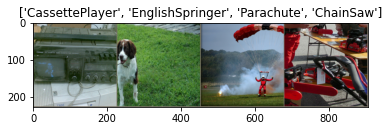

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------



In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.





Resnet18

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate





In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6531 Acc: 0.7968
val Loss: 0.0738 Acc: 0.9754

Training complete in 1m 42s
Best val Acc: 0.975353


Load a trained model

In [9]:
# %cp /content/drive/MyDrive/resnet18.pth .
FILE_NAME = "resnet18.pth"

In [10]:
# load model
loaded_model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = loaded_model_ft.fc.in_features
loaded_model_ft.fc = nn.Linear(num_ftrs, 10)
loaded_model_ft.load_state_dict(torch.load(FILE_NAME)) 
model_conv = loaded_model_ft.to(device)
model_conv.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


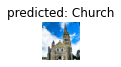

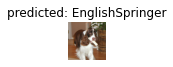

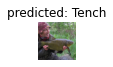

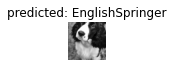

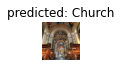

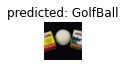

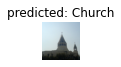

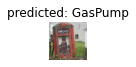

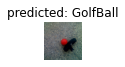

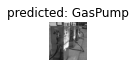

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Differntial Evolution

In [11]:
"""
A slight modification to Scipy's implementation of differential evolution. To speed up predictions, the entire parameters array is passed to `self.func`, where a neural network model can batch its computations.
Taken from
https://github.com/scipy/scipy/blob/70e61dee181de23fdd8d893eaa9491100e2218d7/scipy/optimize/_differentialevolution.py
----------
differential_evolution: The differential evolution global optimization algorithm
Added by Andrew Nelson 2014
"""
from __future__ import division, print_function, absolute_import
import numpy as np
from scipy.optimize import OptimizeResult, minimize
from scipy.optimize.optimize import _status_message
from scipy._lib._util import check_random_state
from scipy._lib.six import xrange, string_types
import warnings


_MACHEPS = np.finfo(np.float64).eps


def differential_evolution(func, bounds, args=(), strategy='best1bin',
                           maxiter=1000, popsize=15, tol=0.01,
                           mutation=(0.5, 1), recombination=0.7, seed=None,
                           callback=None, disp=False, polish=True,
                           init='latinhypercube', atol=0):
    """Finds the global minimum of a multivariate function.
    Differential Evolution is stochastic in nature (does not use gradient
    methods) to find the minimium, and can search large areas of candidate
    space, but often requires larger numbers of function evaluations than
    conventional gradient based techniques.
    The algorithm is due to Storn and Price [1]_.
    Parameters
    ----------
    func : callable
        The objective function to be minimized.  Must be in the form
        ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
        and ``args`` is a  tuple of any additional fixed parameters needed to
        completely specify the function.
    bounds : sequence
        Bounds for variables.  ``(min, max)`` pairs for each element in ``x``,
        defining the lower and upper bounds for the optimizing argument of
        `func`. It is required to have ``len(bounds) == len(x)``.
        ``len(bounds)`` is used to determine the number of parameters in ``x``.
    args : tuple, optional
        Any additional fixed parameters needed to
        completely specify the objective function.
    strategy : str, optional
        The differential evolution strategy to use. Should be one of:
            - 'best1bin'
            - 'best1exp'
            - 'rand1exp'
            - 'randtobest1exp'
            - 'currenttobest1exp'
            - 'best2exp'
            - 'rand2exp'
            - 'randtobest1bin'
            - 'currenttobest1bin'
            - 'best2bin'
            - 'rand2bin'
            - 'rand1bin'
        The default is 'best1bin'.
    maxiter : int, optional
        The maximum number of generations over which the entire population is
        evolved. The maximum number of function evaluations (with no polishing)
        is: ``(maxiter + 1) * popsize * len(x)``
    popsize : int, optional
        A multiplier for setting the total population size.  The population has
        ``popsize * len(x)`` individuals (unless the initial population is
        supplied via the `init` keyword).
    tol : float, optional
        Relative tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    mutation : float or tuple(float, float), optional
        The mutation constant. In the literature this is also known as
        differential weight, being denoted by F.
        If specified as a float it should be in the range [0, 2].
        If specified as a tuple ``(min, max)`` dithering is employed. Dithering
        randomly changes the mutation constant on a generation by generation
        basis. The mutation constant for that generation is taken from
        ``U[min, max)``. Dithering can help speed convergence significantly.
        Increasing the mutation constant increases the search radius, but will
        slow down convergence.
    recombination : float, optional
        The recombination constant, should be in the range [0, 1]. In the
        literature this is also known as the crossover probability, being
        denoted by CR. Increasing this value allows a larger number of mutants
        to progress into the next generation, but at the risk of population
        stability.
    seed : int or `np.random.RandomState`, optional
        If `seed` is not specified the `np.RandomState` singleton is used.
        If `seed` is an int, a new `np.random.RandomState` instance is used,
        seeded with seed.
        If `seed` is already a `np.random.RandomState instance`, then that
        `np.random.RandomState` instance is used.
        Specify `seed` for repeatable minimizations.
    disp : bool, optional
        Display status messages
    callback : callable, `callback(xk, convergence=val)`, optional
        A function to follow the progress of the minimization. ``xk`` is
        the current value of ``x0``. ``val`` represents the fractional
        value of the population convergence.  When ``val`` is greater than one
        the function halts. If callback returns `True`, then the minimization
        is halted (any polishing is still carried out).
    polish : bool, optional
        If True (default), then `scipy.optimize.minimize` with the `L-BFGS-B`
        method is used to polish the best population member at the end, which
        can improve the minimization slightly.
    init : str or array-like, optional
        Specify which type of population initialization is performed. Should be
        one of:
            - 'latinhypercube'
            - 'random'
            - array specifying the initial population. The array should have
              shape ``(M, len(x))``, where len(x) is the number of parameters.
              `init` is clipped to `bounds` before use.
        The default is 'latinhypercube'. Latin Hypercube sampling tries to
        maximize coverage of the available parameter space. 'random'
        initializes the population randomly - this has the drawback that
        clustering can occur, preventing the whole of parameter space being
        covered. Use of an array to specify a population subset could be used,
        for example, to create a tight bunch of initial guesses in an location
        where the solution is known to exist, thereby reducing time for
        convergence.
    atol : float, optional
        Absolute tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a `OptimizeResult` object.
        Important attributes are: ``x`` the solution array, ``success`` a
        Boolean flag indicating if the optimizer exited successfully and
        ``message`` which describes the cause of the termination. See
        `OptimizeResult` for a description of other attributes.  If `polish`
        was employed, and a lower minimum was obtained by the polishing, then
        OptimizeResult also contains the ``jac`` attribute.
    Notes
    -----
    Differential evolution is a stochastic population based method that is
    useful for global optimization problems. At each pass through the population
    the algorithm mutates each candidate solution by mixing with other candidate
    solutions to create a trial candidate. There are several strategies [2]_ for
    creating trial candidates, which suit some problems more than others. The
    'best1bin' strategy is a good starting point for many systems. In this
    strategy two members of the population are randomly chosen. Their difference
    is used to mutate the best member (the `best` in `best1bin`), :math:`b_0`,
    so far:
    .. math::
        b' = b_0 + mutation * (population[rand0] - population[rand1])
    A trial vector is then constructed. Starting with a randomly chosen 'i'th
    parameter the trial is sequentially filled (in modulo) with parameters from
    `b'` or the original candidate. The choice of whether to use `b'` or the
    original candidate is made with a binomial distribution (the 'bin' in
    'best1bin') - a random number in [0, 1) is generated.  If this number is
    less than the `recombination` constant then the parameter is loaded from
    `b'`, otherwise it is loaded from the original candidate.  The final
    parameter is always loaded from `b'`.  Once the trial candidate is built
    its fitness is assessed. If the trial is better than the original candidate
    then it takes its place. If it is also better than the best overall
    candidate it also replaces that.
    To improve your chances of finding a global minimum use higher `popsize`
    values, with higher `mutation` and (dithering), but lower `recombination`
    values. This has the effect of widening the search radius, but slowing
    convergence.
    .. versionadded:: 0.15.0
    Examples
    --------
    Let us consider the problem of minimizing the Rosenbrock function. This
    function is implemented in `rosen` in `scipy.optimize`.
    >>> from scipy.optimize import rosen, differential_evolution
    >>> bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]
    >>> result = differential_evolution(rosen, bounds)
    >>> result.x, result.fun
    (array([1., 1., 1., 1., 1.]), 1.9216496320061384e-19)
    Next find the minimum of the Ackley function
    (http://en.wikipedia.org/wiki/Test_functions_for_optimization).
    >>> from scipy.optimize import differential_evolution
    >>> import numpy as np
    >>> def ackley(x):
    ...     arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    ...     arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    ...     return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e
    >>> bounds = [(-5, 5), (-5, 5)]
    >>> result = differential_evolution(ackley, bounds)
    >>> result.x, result.fun
    (array([ 0.,  0.]), 4.4408920985006262e-16)
    References
    ----------
    .. [1] Storn, R and Price, K, Differential Evolution - a Simple and
           Efficient Heuristic for Global Optimization over Continuous Spaces,
           Journal of Global Optimization, 1997, 11, 341 - 359.
    .. [2] http://www1.icsi.berkeley.edu/~storn/code.html
    .. [3] http://en.wikipedia.org/wiki/Differential_evolution
    """

    solver = DifferentialEvolutionSolver(func, bounds, args=args,
                                         strategy=strategy, maxiter=maxiter,
                                         popsize=popsize, tol=tol,
                                         mutation=mutation,
                                         recombination=recombination,
                                         seed=seed, polish=polish,
                                         callback=callback,
                                         disp=disp, init=init, atol=atol)
    return solver.solve()


class DifferentialEvolutionSolver(object):

    """This class implements the differential evolution solver
    Parameters
    ----------
    func : callable
        The objective function to be minimized.  Must be in the form
        ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
        and ``args`` is a  tuple of any additional fixed parameters needed to
        completely specify the function.
    bounds : sequence
        Bounds for variables.  ``(min, max)`` pairs for each element in ``x``,
        defining the lower and upper bounds for the optimizing argument of
        `func`. It is required to have ``len(bounds) == len(x)``.
        ``len(bounds)`` is used to determine the number of parameters in ``x``.
    args : tuple, optional
        Any additional fixed parameters needed to
        completely specify the objective function.
    strategy : str, optional
        The differential evolution strategy to use. Should be one of:
            - 'best1bin'
            - 'best1exp'
            - 'rand1exp'
            - 'randtobest1exp'
            - 'currenttobest1exp'
            - 'best2exp'
            - 'rand2exp'
            - 'randtobest1bin'
            - 'currenttobest1bin'
            - 'best2bin'
            - 'rand2bin'
            - 'rand1bin'
        The default is 'best1bin'
    maxiter : int, optional
        The maximum number of generations over which the entire population is
        evolved. The maximum number of function evaluations (with no polishing)
        is: ``(maxiter + 1) * popsize * len(x)``
    popsize : int, optional
        A multiplier for setting the total population size.  The population has
        ``popsize * len(x)`` individuals (unless the initial population is
        supplied via the `init` keyword).
    tol : float, optional
        Relative tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    mutation : float or tuple(float, float), optional
        The mutation constant. In the literature this is also known as
        differential weight, being denoted by F.
        If specified as a float it should be in the range [0, 2].
        If specified as a tuple ``(min, max)`` dithering is employed. Dithering
        randomly changes the mutation constant on a generation by generation
        basis. The mutation constant for that generation is taken from
        U[min, max). Dithering can help speed convergence significantly.
        Increasing the mutation constant increases the search radius, but will
        slow down convergence.
    recombination : float, optional
        The recombination constant, should be in the range [0, 1]. In the
        literature this is also known as the crossover probability, being
        denoted by CR. Increasing this value allows a larger number of mutants
        to progress into the next generation, but at the risk of population
        stability.
    seed : int or `np.random.RandomState`, optional
        If `seed` is not specified the `np.random.RandomState` singleton is
        used.
        If `seed` is an int, a new `np.random.RandomState` instance is used,
        seeded with `seed`.
        If `seed` is already a `np.random.RandomState` instance, then that
        `np.random.RandomState` instance is used.
        Specify `seed` for repeatable minimizations.
    disp : bool, optional
        Display status messages
    callback : callable, `callback(xk, convergence=val)`, optional
        A function to follow the progress of the minimization. ``xk`` is
        the current value of ``x0``. ``val`` represents the fractional
        value of the population convergence.  When ``val`` is greater than one
        the function halts. If callback returns `True`, then the minimization
        is halted (any polishing is still carried out).
    polish : bool, optional
        If True, then `scipy.optimize.minimize` with the `L-BFGS-B` method
        is used to polish the best population member at the end. This requires
        a few more function evaluations.
    maxfun : int, optional
        Set the maximum number of function evaluations. However, it probably
        makes more sense to set `maxiter` instead.
    init : str or array-like, optional
        Specify which type of population initialization is performed. Should be
        one of:
            - 'latinhypercube'
            - 'random'
            - array specifying the initial population. The array should have
              shape ``(M, len(x))``, where len(x) is the number of parameters.
              `init` is clipped to `bounds` before use.
        The default is 'latinhypercube'. Latin Hypercube sampling tries to
        maximize coverage of the available parameter space. 'random'
        initializes the population randomly - this has the drawback that
        clustering can occur, preventing the whole of parameter space being
        covered. Use of an array to specify a population could be used, for
        example, to create a tight bunch of initial guesses in an location
        where the solution is known to exist, thereby reducing time for
        convergence.
    atol : float, optional
        Absolute tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    """

    # Dispatch of mutation strategy method (binomial or exponential).
    _binomial = {'best1bin': '_best1',
                 'randtobest1bin': '_randtobest1',
                 'currenttobest1bin': '_currenttobest1',
                 'best2bin': '_best2',
                 'rand2bin': '_rand2',
                 'rand1bin': '_rand1'}
    _exponential = {'best1exp': '_best1',
                    'rand1exp': '_rand1',
                    'randtobest1exp': '_randtobest1',
                    'currenttobest1exp': '_currenttobest1',
                    'best2exp': '_best2',
                    'rand2exp': '_rand2'}

    __init_error_msg = ("The population initialization method must be one of "
                        "'latinhypercube' or 'random', or an array of shape "
                        "(M, N) where N is the number of parameters and M>5")

    def __init__(self, func, bounds, args=(),
                 strategy='best1bin', maxiter=1000, popsize=15,
                 tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None,
                 maxfun=np.inf, callback=None, disp=False, polish=True,
                 init='latinhypercube', atol=0):

        if strategy in self._binomial:
            self.mutation_func = getattr(self, self._binomial[strategy])
        elif strategy in self._exponential:
            self.mutation_func = getattr(self, self._exponential[strategy])
        else:
            raise ValueError("Please select a valid mutation strategy")
        self.strategy = strategy

        self.callback = callback
        self.polish = polish

        # relative and absolute tolerances for convergence
        self.tol, self.atol = tol, atol

        # Mutation constant should be in [0, 2). If specified as a sequence
        # then dithering is performed.
        self.scale = mutation
        if (not np.all(np.isfinite(mutation)) or
                np.any(np.array(mutation) >= 2) or
                np.any(np.array(mutation) < 0)):
            raise ValueError('The mutation constant must be a float in '
                             'U[0, 2), or specified as a tuple(min, max)'
                             ' where min < max and min, max are in U[0, 2).')

        self.dither = None
        if hasattr(mutation, '__iter__') and len(mutation) > 1:
            self.dither = [mutation[0], mutation[1]]
            self.dither.sort()

        self.cross_over_probability = recombination

        self.func = func
        self.args = args

        # convert tuple of lower and upper bounds to limits
        # [(low_0, high_0), ..., (low_n, high_n]
        #     -> [[low_0, ..., low_n], [high_0, ..., high_n]]
        self.limits = np.array(bounds, dtype='float').T
        if (np.size(self.limits, 0) != 2 or not
                np.all(np.isfinite(self.limits))):
            raise ValueError('bounds should be a sequence containing '
                             'real valued (min, max) pairs for each value'
                             ' in x')

        if maxiter is None:  # the default used to be None
            maxiter = 1000
        self.maxiter = maxiter
        if maxfun is None:  # the default used to be None
            maxfun = np.inf
        self.maxfun = maxfun

        # population is scaled to between [0, 1].
        # We have to scale between parameter <-> population
        # save these arguments for _scale_parameter and
        # _unscale_parameter. This is an optimization
        self.__scale_arg1 = 0.5 * (self.limits[0] + self.limits[1])
        self.__scale_arg2 = np.fabs(self.limits[0] - self.limits[1])

        self.parameter_count = np.size(self.limits, 1)

        self.random_number_generator = check_random_state(seed)

        # default population initialization is a latin hypercube design, but
        # there are other population initializations possible.
        # the minimum is 5 because 'best2bin' requires a population that's at
        # least 5 long
        self.num_population_members = max(5, popsize * self.parameter_count)

        self.population_shape = (self.num_population_members,
                                 self.parameter_count)

        self._nfev = 0
        if isinstance(init, string_types):
            if init == 'latinhypercube':
                self.init_population_lhs()
            elif init == 'random':
                self.init_population_random()
            else:
                raise ValueError(self.__init_error_msg)
        else:
            self.init_population_array(init)

        self.disp = disp

    def init_population_lhs(self):
        """
        Initializes the population with Latin Hypercube Sampling.
        Latin Hypercube Sampling ensures that each parameter is uniformly
        sampled over its range.
        """
        rng = self.random_number_generator

        # Each parameter range needs to be sampled uniformly. The scaled
        # parameter range ([0, 1)) needs to be split into
        # `self.num_population_members` segments, each of which has the following
        # size:
        segsize = 1.0 / self.num_population_members

        # Within each segment we sample from a uniform random distribution.
        # We need to do this sampling for each parameter.
        samples = (segsize * rng.random_sample(self.population_shape)

        # Offset each segment to cover the entire parameter range [0, 1)
                   + np.linspace(0., 1., self.num_population_members,
                                 endpoint=False)[:, np.newaxis])

        # Create an array for population of candidate solutions.
        self.population = np.zeros_like(samples)

        # Initialize population of candidate solutions by permutation of the
        # random samples.
        for j in range(self.parameter_count):
            order = rng.permutation(range(self.num_population_members))
            self.population[:, j] = samples[order, j]

        # reset population energies
        self.population_energies = (np.ones(self.num_population_members) *
                                    np.inf)

        # reset number of function evaluations counter
        self._nfev = 0

    def init_population_random(self):
        """
        Initialises the population at random.  This type of initialization
        can possess clustering, Latin Hypercube sampling is generally better.
        """
        rng = self.random_number_generator
        self.population = rng.random_sample(self.population_shape)

        # reset population energies
        self.population_energies = (np.ones(self.num_population_members) *
                                    np.inf)

        # reset number of function evaluations counter
        self._nfev = 0

    def init_population_array(self, init):
        """
        Initialises the population with a user specified population.
        Parameters
        ----------
        init : np.ndarray
            Array specifying subset of the initial population. The array should
            have shape (M, len(x)), where len(x) is the number of parameters.
            The population is clipped to the lower and upper `bounds`.
        """
        # make sure you're using a float array
        popn = np.asfarray(init)

        if (np.size(popn, 0) < 5 or
                popn.shape[1] != self.parameter_count or
                len(popn.shape) != 2):
            raise ValueError("The population supplied needs to have shape"
                             " (M, len(x)), where M > 4.")

        # scale values and clip to bounds, assigning to population
        self.population = np.clip(self._unscale_parameters(popn), 0, 1)

        self.num_population_members = np.size(self.population, 0)

        self.population_shape = (self.num_population_members,
                                 self.parameter_count)

        # reset population energies
        self.population_energies = (np.ones(self.num_population_members) *
                                    np.inf)

        # reset number of function evaluations counter
        self._nfev = 0

    @property
    def x(self):
        """
        The best solution from the solver
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        """
        return self._scale_parameters(self.population[0])

    @property
    def convergence(self):
        """
        The standard deviation of the population energies divided by their
        mean.
        """
        return (np.std(self.population_energies) /
                np.abs(np.mean(self.population_energies) + _MACHEPS))

    def solve(self):
        """
        Runs the DifferentialEvolutionSolver.
        Returns
        -------
        res : OptimizeResult
            The optimization result represented as a ``OptimizeResult`` object.
            Important attributes are: ``x`` the solution array, ``success`` a
            Boolean flag indicating if the optimizer exited successfully and
            ``message`` which describes the cause of the termination. See
            `OptimizeResult` for a description of other attributes.  If `polish`
            was employed, and a lower minimum was obtained by the polishing,
            then OptimizeResult also contains the ``jac`` attribute.
        """
        nit, warning_flag = 0, False
        status_message = _status_message['success']

        # The population may have just been initialized (all entries are
        # np.inf). If it has you have to calculate the initial energies.
        # Although this is also done in the evolve generator it's possible
        # that someone can set maxiter=0, at which point we still want the
        # initial energies to be calculated (the following loop isn't run).
        if np.all(np.isinf(self.population_energies)):
            self._calculate_population_energies()

        # do the optimisation.
        for nit in xrange(1, self.maxiter + 1):
            # evolve the population by a generation
            try:
                next(self)
            except StopIteration:
                warning_flag = True
                status_message = _status_message['maxfev']
                break

            if self.disp:
                print("differential_evolution step %d: f(x)= %g"
                      % (nit,
                         self.population_energies[0]))

            # should the solver terminate?
            convergence = self.convergence

            if (self.callback and
                    self.callback(self._scale_parameters(self.population[0]),
                                  convergence=self.tol / convergence) is True):

                warning_flag = True
                status_message = ('callback function requested stop early '
                                  'by returning True')
                break

            intol = (np.std(self.population_energies) <=
                     self.atol +
                     self.tol * np.abs(np.mean(self.population_energies)))
            if warning_flag or intol:
                break

        else:
            status_message = _status_message['maxiter']
            warning_flag = True

        DE_result = OptimizeResult(
            x=self.x,
            fun=self.population_energies[0],
            nfev=self._nfev,
            nit=nit,
            message=status_message,
            success=(warning_flag is not True))

        if self.polish:
            result = minimize(self.func,
                              np.copy(DE_result.x),
                              method='L-BFGS-B',
                              bounds=self.limits.T,
                              args=self.args)

            self._nfev += result.nfev
            DE_result.nfev = self._nfev

            if result.fun < DE_result.fun:
                DE_result.fun = result.fun
                DE_result.x = result.x
                DE_result.jac = result.jac
                # to keep internal state consistent
                self.population_energies[0] = result.fun
                self.population[0] = self._unscale_parameters(result.x)

        return DE_result

    def _calculate_population_energies(self):
        """
        Calculate the energies of all the population members at the same time.
        Puts the best member in first place. Useful if the population has just
        been initialised.
        """

        ##############
        ## CHANGES: self.func operates on the entire parameters array
        ##############
        itersize = max(0, min(len(self.population), self.maxfun - self._nfev + 1))
        candidates = self.population[:itersize]
        parameters = np.array([self._scale_parameters(c) for c in candidates]) # TODO: vectorize
        energies = self.func(parameters, *self.args)
        self.population_energies = energies
        self._nfev += itersize

        # for index, candidate in enumerate(self.population):
        #     if self._nfev > self.maxfun:
        #         break

        #     parameters = self._scale_parameters(candidate)
        #     self.population_energies[index] = self.func(parameters,
        #                                                 *self.args)
        #     self._nfev += 1

        ##############
        ##############

        

        minval = np.argmin(self.population_energies)

        # put the lowest energy into the best solution position.
        lowest_energy = self.population_energies[minval]
        self.population_energies[minval] = self.population_energies[0]
        self.population_energies[0] = lowest_energy

        self.population[[0, minval], :] = self.population[[minval, 0], :]

    def __iter__(self):
        return self

    def __next__(self):
        """
        Evolve the population by a single generation
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        fun : float
            Value of objective function obtained from the best solution.
        """
        # the population may have just been initialized (all entries are
        # np.inf). If it has you have to calculate the initial energies
        if np.all(np.isinf(self.population_energies)):
            self._calculate_population_energies()

        if self.dither is not None:
            self.scale = (self.random_number_generator.rand()
                          * (self.dither[1] - self.dither[0]) + self.dither[0])

        ##############
        ## CHANGES: self.func operates on the entire parameters array
        ##############

        itersize = max(0, min(self.num_population_members, self.maxfun - self._nfev + 1))
        trials = np.array([self._mutate(c) for c in range(itersize)]) # TODO: vectorize
        for trial in trials: self._ensure_constraint(trial)
        parameters = np.array([self._scale_parameters(trial) for trial in trials])
        energies = self.func(parameters, *self.args)
        self._nfev += itersize

        for candidate,(energy,trial) in enumerate(zip(energies, trials)):
            # if the energy of the trial candidate is lower than the
            # original population member then replace it
            if energy < self.population_energies[candidate]:
                self.population[candidate] = trial
                self.population_energies[candidate] = energy

                # if the trial candidate also has a lower energy than the
                # best solution then replace that as well
                if energy < self.population_energies[0]:
                    self.population_energies[0] = energy
                    self.population[0] = trial

        # for candidate in range(self.num_population_members):
        #     if self._nfev > self.maxfun:
        #         raise StopIteration

        #     # create a trial solution
        #     trial = self._mutate(candidate)

        #     # ensuring that it's in the range [0, 1)
        #     self._ensure_constraint(trial)

        #     # scale from [0, 1) to the actual parameter value
        #     parameters = self._scale_parameters(trial)

        #     # determine the energy of the objective function
        #     energy = self.func(parameters, *self.args)
        #     self._nfev += 1

        #     # if the energy of the trial candidate is lower than the
        #     # original population member then replace it
        #     if energy < self.population_energies[candidate]:
        #         self.population[candidate] = trial
        #         self.population_energies[candidate] = energy

        #         # if the trial candidate also has a lower energy than the
        #         # best solution then replace that as well
        #         if energy < self.population_energies[0]:
        #             self.population_energies[0] = energy
        #             self.population[0] = trial

        ##############
        ##############

        return self.x, self.population_energies[0]

    def next(self):
        """
        Evolve the population by a single generation
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        fun : float
            Value of objective function obtained from the best solution.
        """
        # next() is required for compatibility with Python2.7.
        return self.__next__()

    def _scale_parameters(self, trial):
        """
        scale from a number between 0 and 1 to parameters.
        """
        return self.__scale_arg1 + (trial - 0.5) * self.__scale_arg2

    def _unscale_parameters(self, parameters):
        """
        scale from parameters to a number between 0 and 1.
        """
        return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5

    def _ensure_constraint(self, trial):
        """
        make sure the parameters lie between the limits
        """
        for index in np.where((trial < 0) | (trial > 1))[0]:
            trial[index] = self.random_number_generator.rand()

    def _mutate(self, candidate):
        """
        create a trial vector based on a mutation strategy
        """
        trial = np.copy(self.population[candidate])

        rng = self.random_number_generator

        fill_point = rng.randint(0, self.parameter_count)

        if self.strategy in ['currenttobest1exp', 'currenttobest1bin']:
            bprime = self.mutation_func(candidate,
                                        self._select_samples(candidate, 5))
        else:
            bprime = self.mutation_func(self._select_samples(candidate, 5))

        if self.strategy in self._binomial:
            crossovers = rng.rand(self.parameter_count)
            crossovers = crossovers < self.cross_over_probability
            # the last one is always from the bprime vector for binomial
            # If you fill in modulo with a loop you have to set the last one to
            # true. If you don't use a loop then you can have any random entry
            # be True.
            crossovers[fill_point] = True
            trial = np.where(crossovers, bprime, trial)
            return trial

        elif self.strategy in self._exponential:
            i = 0
            while (i < self.parameter_count and
                   rng.rand() < self.cross_over_probability):

                trial[fill_point] = bprime[fill_point]
                fill_point = (fill_point + 1) % self.parameter_count
                i += 1

            return trial

    def _best1(self, samples):
        """
        best1bin, best1exp
        """
        r0, r1 = samples[:2]
        return (self.population[0] + self.scale *
                (self.population[r0] - self.population[r1]))

    def _rand1(self, samples):
        """
        rand1bin, rand1exp
        """
        r0, r1, r2 = samples[:3]
        return (self.population[r0] + self.scale *
                (self.population[r1] - self.population[r2]))

    def _randtobest1(self, samples):
        """
        randtobest1bin, randtobest1exp
        """
        r0, r1, r2 = samples[:3]
        bprime = np.copy(self.population[r0])
        bprime += self.scale * (self.population[0] - bprime)
        bprime += self.scale * (self.population[r1] -
                                self.population[r2])
        return bprime

    def _currenttobest1(self, candidate, samples):
        """
        currenttobest1bin, currenttobest1exp
        """
        r0, r1 = samples[:2]
        bprime = (self.population[candidate] + self.scale * 
                  (self.population[0] - self.population[candidate] +
                   self.population[r0] - self.population[r1]))
        return bprime

    def _best2(self, samples):
        """
        best2bin, best2exp
        """
        r0, r1, r2, r3 = samples[:4]
        bprime = (self.population[0] + self.scale *
                  (self.population[r0] + self.population[r1] -
                   self.population[r2] - self.population[r3]))

        return bprime

    def _rand2(self, samples):
        """
        rand2bin, rand2exp
        """
        r0, r1, r2, r3, r4 = samples
        bprime = (self.population[r0] + self.scale *
                  (self.population[r1] + self.population[r2] -
                   self.population[r3] - self.population[r4]))

        return bprime

    def _select_samples(self, candidate, number_samples):
        """
        obtain random integers from range(self.num_population_members),
        without replacement.  You can't have the original candidate either.
        """
        idxs = list(range(self.num_population_members))
        idxs.remove(candidate)
        self.random_number_generator.shuffle(idxs)
        idxs = idxs[:number_samples]
        return idxs

# Attack 

In [12]:
import os
import sys
import numpy as np

import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable


def perturb_image(xs, img):
	if xs.ndim < 2:
		xs = np.array([xs])
	batch = len(xs)
	imgs = img.repeat(batch, 1, 1, 1)
	xs = xs.astype(int)

	count = 0
	for x in xs:
		pixels = np.split(x, len(x)/5)
		
		for pixel in pixels:
			x_pos, y_pos, r, g, b = pixel
			imgs[count, 0, x_pos, y_pos] = (r /255.0-0.4914)/0.2023
			imgs[count, 1, x_pos, y_pos] = (g /255.0-0.4822)/0.1994
			imgs[count, 2, x_pos, y_pos] = (b /255.0-0.4465)/0.2010
		count += 1

	return imgs

def predict_classes(xs, img, target_calss, net, minimize=True):
	imgs_perturbed = perturb_image(xs, img.clone())
	input = Variable(imgs_perturbed, volatile=True).cuda()
	predictions = F.softmax(net(input)).data.cpu().numpy()[:, target_calss]

	return predictions if minimize else 1 - predictions

def attack_success(x, img, target_calss, net, targeted_attack=False, verbose=False):

	attack_image = perturb_image(x, img.clone())
	input = Variable(attack_image, volatile=True).cuda()
	confidence = F.softmax(net(input)).data.cpu().numpy()[0]
	predicted_class = np.argmax(confidence)

	if (verbose):
		print ("Confidence: %.4f"%confidence[target_calss])
	if (targeted_attack and predicted_class == target_calss) or (not targeted_attack and predicted_class != target_calss):
		return True


def attack(img, label, net, target=None, pixels=1, maxiter=75, popsize=400, verbose=False):
	# img: 1*3*W*H tensor
	# label: a number

	targeted_attack = target is not None
	target_calss = target if targeted_attack else label

	bounds = [(0,224), (0,224), (0,255), (0,255), (0,255)] * pixels

	popmul = max(1, int(popsize/len(bounds)))

	predict_fn = lambda xs: predict_classes(
		xs, img, target_calss, net, target is None)
	callback_fn = lambda x, convergence: attack_success(
		x, img, target_calss, net, targeted_attack, verbose)

	inits = np.zeros([popmul*len(bounds), len(bounds)])
	for init in inits:
		for i in range(pixels):
			init[i*5+0] = np.random.random()*224
			init[i*5+1] = np.random.random()*224
			init[i*5+2] = np.random.normal(128,127)
			init[i*5+3] = np.random.normal(128,127)
			init[i*5+4] = np.random.normal(128,127)

	attack_result = differential_evolution(predict_fn, bounds, maxiter=maxiter, popsize=popmul,
		recombination=1, atol=-1, callback=callback_fn, polish=False, init=inits)

	attack_image = perturb_image(attack_result.x, img)
	attack_var = Variable(attack_image, volatile=True).cuda()
	predicted_probs = F.softmax(net(attack_var)).data.cpu().numpy()[0]

	predicted_class = np.argmax(predicted_probs)

	if (not targeted_attack and predicted_class != label) or (targeted_attack and predicted_class == target_calss):
		return 1, attack_result.x.astype(int)
	return 0, [None]




In [13]:
def visualize_attack(xs,img,net):
  p = F.softmax(net(img.to(device).unsqueeze(0)))
  original_predicted_class = class_names[torch.argmax(p).item()]
  original_confidence = torch.max(p).item()

  p_img = perturb_image(xs,img).to(device)
  attack_p = F.softmax(net(p_img))
  attack_class = class_names[torch.argmax(attack_p).item()]
  attack_confidence = torch.max(attack_p).item()
  imshow(p_img.squeeze().cpu(),title=f'{original_predicted_class}({original_confidence})\ {attack_class}({attack_confidence})')



In [14]:
attack_dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

In [15]:
import pandas as pd 

In [ ]:
resnet18_success = 0
inputs,labels = next(iter(attack_dataloaders['val']))

batch_size = 128

results_resnet18 = pd.DataFrame(columns=['pixels','model_accuracy','success_rate','time'])

since = time.time()


for pixel in [31,64]:
  start = time.time()
  success_counter = 0
  acc = 0
  for img,lbl in zip(inputs,labels):
    success,xs = attack(img,lbl,model_conv,pixels=pixel)
    prior_pred = torch.argmax(model_conv(img.to(device).unsqueeze(0)))
    acc += int(prior_pred == lbl)
    success_counter += success
  time_elapsed = time.time() - start
  results_resnet18 = results_resnet18.append(
      {'pixels':pixel,'model_accuracy': acc/batch_size,'success_rate':success_counter/batch_size,'time':time_elapsed},ignore_index=True)
  print(f'pixels:{pixel}, success rate: {success_counter/batch_size}')





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the cal

pixels:31, success rate: 0.0546875


In [ ]:
results_resnet18.to_csv('results_resnet18.csv')
